# Import and misc

In [ ]:
# Instal latest torch and torchaudio

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [2]:
import random

def set_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seed()

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 20
    temperature: float = 5.0

# Data

In [12]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 16:54:57--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.107.128, 2607:f8b0:400c:c32::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.107.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   250MB/s    in 7.5s    

2022-11-06 16:55:05 (190 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [ ]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [ ]:
dataset.csv.sample(5)

,path,keyword,label
50866,speech_commands/two/f4cae173_nohash_0.wav,two,0
1003,speech_commands/happy/d3a18257_nohash_1.wav,happy,0
38126,speech_commands/right/471a0925_nohash_0.wav,right,0
144,speech_commands/happy/518588b6_nohash_1.wav,happy,0
31651,speech_commands/go/5588c7e6_nohash_0.wav,go,0


### Augmentations

In [ ]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [ ]:
set_random_seed()
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [ ]:
# Sample is a dict of utt, word and label
set_random_seed()
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [ ]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [ ]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [ ]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [ ]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [ ]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

    def to(self, device):
        self.melspec = self.melspec.to(device)

In [ ]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [ ]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [ ]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Teacher Model

In [4]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
config

TaskConfig(keyword='sheila', batch_size=128, learning_rate=0.0003, weight_decay=1e-05, num_epochs=40, n_mels=40, cnn_out_channels=8, kernel_size=(5, 20), stride=(2, 8), hidden_size=64, gru_num_layers=2, bidirectional=False, num_classes=2, sample_rate=16000, device=device(type='cuda', index=0), max_window_length=20, temperature=5.0)

In [ ]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [ ]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() / torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [6]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training teacher model

In [ ]:
set_random_seed()
config = TaskConfig(hidden_size=32)
teacher_model = CRNN(config).to(config.device)

print(teacher_model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in teacher_model.parameters()])

25387

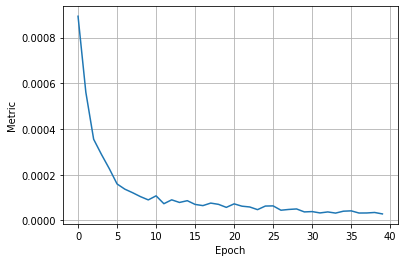

END OF EPOCH 39


In [ ]:
# TRAIN
set_random_seed()
for n in range(config.num_epochs):

    train_epoch(teacher_model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
compiled_model = torch.jit.script(teacher_model)
torch.jit.save(compiled_model, 'teacher_model.pt')

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0008932225219422994,
              0.0005604661012713711,
              0.0003550541622077897,
              0.00028862342253474266,
              0.0002266892299640709,
              0.0001595185143909648,
              0.00013662103432220073,
              0.00012106363777821639,
              0.00010401435433895162,
              8.973401297732733e-05,
              0.00010749343457874558,
              7.30726201308355e-05,
              9.000852016605894e-05,
              7.856873145304861e-05,
              8.62609002851145e-05,
              6.993965765074659e-05,
              6.47478912551707e-05,
              7.575801654234027e-05,
              7.027384031528941e-05,
              5.704378732794255e-05,
              7.243409253965547e-05,
              6.22773265565863e-05,
              5.876840857888673e-05,
              4.7107820605374886e-05,
              6.279053564856278e-05,
              6.351260890587849e-05,
    

# Decorators for computations

In [ ]:
import time


class Timer:

    def __init__(self, name: str, verbose=False):
        self.name = name
        self.verbose = verbose

    def __enter__(self):
        self.t = time.time()
        return self

    def __exit__(self, type, value, traceback):
        self.t = time.time() - self.t

        if self.verbose:
            print(f"{self.name.capitalize()} | Elapsed time : {self.t:.10f}")

In [ ]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from thop import profile  # !pip install thop

# Usage example:
# profile(Model(), (torch.randn(1, 1, 4), ))

In [ ]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

In [ ]:
def compute_metrics(model, device):
    # making 2 second recording for test
    batch = next(iter(train_loader))[0][:2, :]
    melspec_train.to(device)
    long_wav = melspec_train(torch.cat([batch[0, :], batch[1, :]]).unsqueeze(0).to(device))
    with Timer("", verbose=True) as t:
        with torch.no_grad():
            _ = model(long_wav)
    time = t.t
    macs, params = profile(model, (long_wav, ))
    print(f"MAC'c: {macs}")
    size = get_size_in_megabytes(model)
    print(f"Size of model: {size}")
    return time, macs, size

# Teacher metrics

In [ ]:
teacher_t, teacher_macs, teacher_size = compute_metrics(teacher_model, config.device)

 | Elapsed time : 3.5237913132
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 904608.0
Size of model: 0.10240364074707031


# Distillation train functions

In [ ]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

In [5]:
@dataclasses.dataclass
class SmallConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 40
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 20
    gru_num_layers: int = 1
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
    max_window_length: int = 40
    temperature: float = 5.0
    teacher_loss_coeff: float = 0.5
    attention_dim: int = 10

In [ ]:
def softmax_with_temp(logits, temp=1):
    return F.softmax(logits / temp, dim=-1)

def train_epoch_distil(model, teacher, opt, loader, log_melspec, device, config):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        with torch.no_grad():
            teacher_logits = teacher(batch)
        # we need probabilities so we use softmax & CE separately
        probs = softmax_with_temp(logits)
        true_loss = F.cross_entropy(logits, labels)
        teacher_loss = F.cross_entropy(
                                    softmax_with_temp(logits, config.temperature),
                                    softmax_with_temp(teacher_logits, config.temperature)
        )
        loss =  (1 - config.teacher_loss_coeff) * true_loss + config.teacher_loss_coeff * teacher_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train(model, teacher_model, config, history):
    set_random_seed()
    for n in range(config.num_epochs):

        train_epoch_distil(model, teacher_model, opt, train_loader,
                    melspec_train, config.device, config)

        au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)

# Base distillation model

In [ ]:
set_random_seed()
history = defaultdict(list)
config = SmallConfig()
model = CRNN(config).to(config.device)

print("model: \n", model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
teacher_model = torch.jit.load('teacher_model.pt').to(config.device).eval()
print("teacher model: \n", teacher_model)

model: 
 CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 20, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=20, out_features=2, bias=True)
)
teacher model: 
 RecursiveScriptModule(
  original_name=CRNN
  (conv): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=Flatten)
  )
  (gru): RecursiveScriptModule(original_name=GRU)
  (attention): RecursiveScriptModule(
    original_name=Attention
    (energy): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(original_name=Linear)
      (1): RecursiveScriptModule(original_name=Tanh)
      (2):

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"time: {teacher_t / t}")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")

 | Elapsed time : 0.0044858456
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 573200.0
Size of model: 0.04814338684082031

Compression_rate: 
time: 769.5385596598459
MACs: 1.578171667829728
size in Mb: 2.1270551879877977


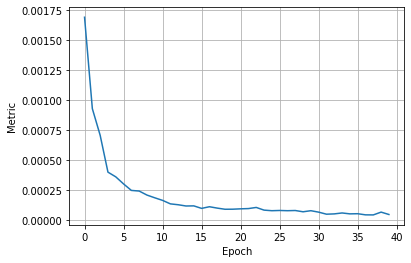

END OF EPOCH 39


In [ ]:
train(model, teacher_model, config, history)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.001693530328046534,
              0.0009316057879840744,
              0.0007102694482002697,
              0.00040272591605958056,
              0.0003636146092129088,
              0.00030455677457633774,
              0.00025050571236032767,
              0.000245224432751035,
              0.00021166294515480636,
              0.00018899223189412496,
              0.00016743446625732273,
              0.0001384232336916995,
              0.0001311010528096631,
              0.00012071155247093021,
              0.0001216872465004436,
              0.00010075607335965916,
              0.00011455901091479371,
              0.00010309535201145888,
              9.34726815369001e-05,
              9.401871214057274e-05,
              9.706812895452594e-05,
              9.919555966719584e-05,
              0.00010864517126190208,
              8.62907380230201e-05,
              8.143912183956814e-05,
              8.338454235101384e-05,

In [ ]:
torch.save(model.state_dict(), "distilled_model.pth")

# Dark Knowledge Distillation

### Experiment with cnn_output_ch

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


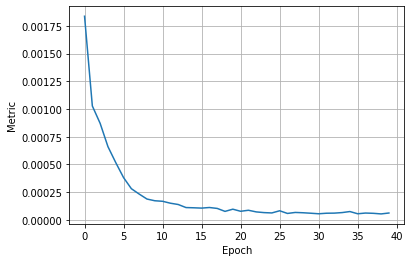

END OF EPOCH 39


In [ ]:
cnn_ch = [3, 4, 5, 6]
ts = []
macss = []
memory = []
val_score = []
best_epoch = []

for ch in cnn_ch:
    print(f"Channel {ch}")
    set_random_seed()
    history = defaultdict(list)
    config = SmallConfig(cnn_out_channels=ch)
    model = CRNN(config).to(config.device)
    opt = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    t, macs, size = compute_metrics(model, config.device)
    ts.append(t)
    macss.append(macs)
    memory.append(size)
    train(model, teacher_model, config, history)
    val = np.array(history["val_metric"])
    val_score.append(val.min())
    best_epoch.append(val.argmin())
    torch.save(model.state_dict(), f'/content/drive/MyDrive/distill_cnn_{ch}.pth')

In [ ]:
val_score, best_epoch

([0.00012330146812113705,
  4.951274228056693e-05,
  9.636395833995358e-05,
  5.317681649537567e-05],
 [34, 37, 38, 38])

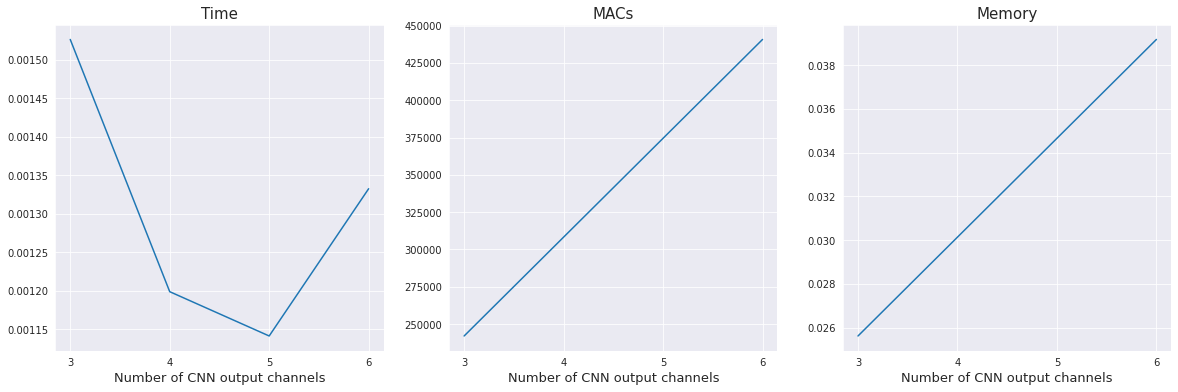

In [ ]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(20)
ax1.plot(cnn_ch, ts)
ax1.set_title("Time", fontsize=15)
ax1.set_xlabel("Number of CNN output channels", fontsize=13)
ax1.set_xticks(cnn_ch)
ax2.plot(cnn_ch, macss)
ax2.set_title("MACs", fontsize=15)
ax2.set_xticks(cnn_ch)
ax2.set_xlabel("Number of CNN output channels", fontsize=13)
ax3.plot(cnn_ch, memory)
ax3.set_title("Memory", fontsize=15)
ax3.set_xlabel("Number of CNN output channels", fontsize=13)
ax3.set_xticks(cnn_ch)
plt.show()

3 channels is not enough according to the value-score results. So I'll be using cnn_output_ch=4 for the following experiments.

In [ ]:
print(f"Compression_rate: ")
print(f"time: {teacher_t / ts[1]}")
print(f"MACs: {teacher_macs / macss[1]}")
print(f"size in Mb: {teacher_size / memory[1]}")

Compression_rate: 
time: 2.1906939749453174
MACs: 2.9347521411886843
size in Mb: 3.3978229225998353


### Experiment with hidden_size of gru

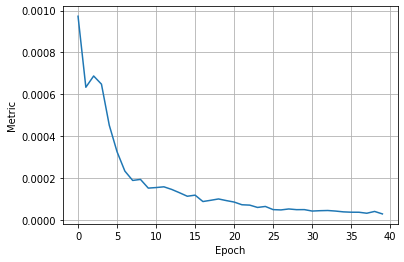

END OF EPOCH 39


In [ ]:
hidden = [5, 10, 15]
ts = []
macss = []
memory = []
val_score = []
best_epoch = []

for h in hidden:
    print(f"Hidden size {h}")
    set_random_seed()
    history = defaultdict(list)
    config = SmallConfig(cnn_out_channels=4, hidden_size=h)
    model = CRNN(config).to(config.device)
    opt = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    t, macs, size = compute_metrics(model, config.device)
    ts.append(t)
    macss.append(macs)
    memory.append(size)
    train(model, teacher_model, config, history)
    val = np.array(history["val_metric"])
    val_score.append(val.min())
    best_epoch.append(val.argmin())
    torch.save(model.state_dict(), f'/content/drive/MyDrive/distill_hidden_{h}.pth')

In [ ]:
val_score, best_epoch

([0.000248560291848882, 0.00010940304980470455, 2.8805352174074557e-05],
 [39, 39, 39])

We see that small models can't achieve necessary metric on val dataset.

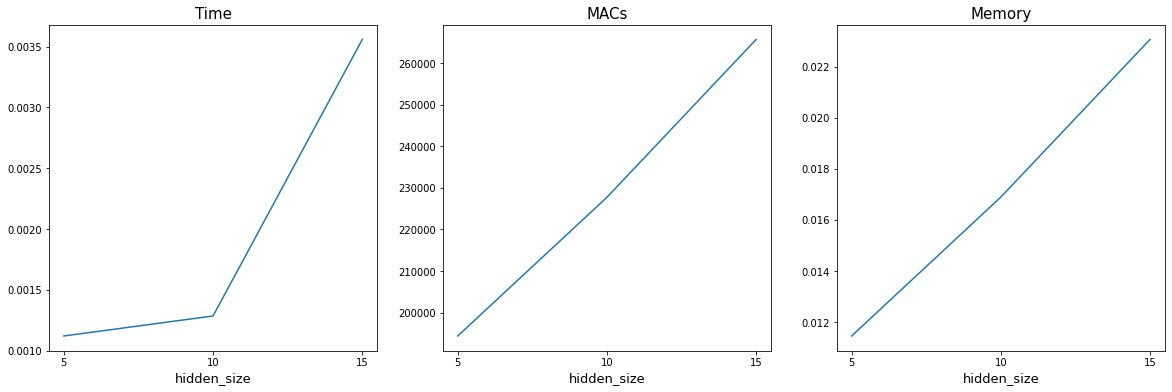

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(20)
ax1.plot(hidden, ts)
ax1.set_title("Time", fontsize=15)
ax1.set_xlabel("hidden_size", fontsize=13)
ax1.set_xticks(hidden)
ax2.plot(hidden, macss)
ax2.set_title("MACs", fontsize=15)
ax2.set_xticks(hidden)
ax2.set_xlabel("hidden_size", fontsize=13)
ax3.plot(hidden, memory)
ax3.set_title("Memory", fontsize=15)
ax3.set_xlabel("hidden_size", fontsize=13)
ax3.set_xticks(hidden)
plt.show()

I misclicked on the cell below, but I saved the resulting model, so I computed compression rate according to it.

In [ ]:
config = SmallConfig(cnn_out_channels=4, hidden_size=15)
model = CRNN(config).to(config.device)
model.load_state_dict(torch.load('/content/drive/MyDrive/distill_hidden_15.pth'), strict=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params', 'conv.1.total_ops', 'conv.1.total_params', 'attention.total_ops', 'attention.total_params', 'attention.energy.1.total_ops', 'attention.energy.1.total_params'])

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:06, 16.84it/s]


2.8805352174074557e-05

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"time: {teacher_t / t}")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0010890961
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 265680.0
Size of model: 0.023057937622070312

Compression_rate: 
time: 2.2791155866900175
MACs: 3.4048780487804877
size in Mb: 4.441144842418728
number of parameters:  5.40493932297211


# Attention Distillation

In [7]:
class AttentionDistilled(nn.Module):

    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNNSmall(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = AttentionDistilled(config.hidden_size, config.attention_dim)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output


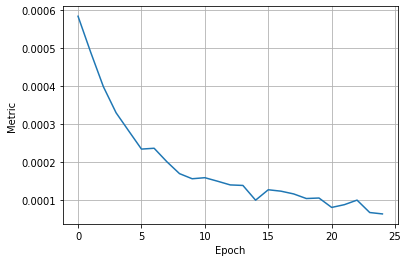

END OF EPOCH 24
 | Elapsed time : 0.0012919903
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 264576.0
Size of model: 0.022874832153320312


In [ ]:
att_dim = [5, 8, 10, 12]
ts = []
macss = []
memory = []
val_score = []
best_epoch = []

for att in att_dim:
    print(f"Attention size {att}")
    set_random_seed()
    history = defaultdict(list)
    config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=att, num_epochs=25)
    model = CRNNSmall(config).to(config.device)
    opt = torch.optim.Adam(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    train(model, teacher_model, config, history)
    t, macs, size = compute_metrics(model, config.device)
    ts.append(t)
    macss.append(macs)
    memory.append(size)
    val = np.array(history["val_metric"])
    val_score.append(val.min())
    best_epoch.append(val.argmin())
    torch.save(model.state_dict(), f'/content/drive/MyDrive/distill_att_{att}.pth')
    if val_score[-1] < 5.5e-5:
        break

In [ ]:
val_score, best_epoch

([0.00010740392136502876,
  0.00010779181195780168,
  0.00010104848319113412,
  6.399001271236823e-05],
 [24, 21, 20, 24])

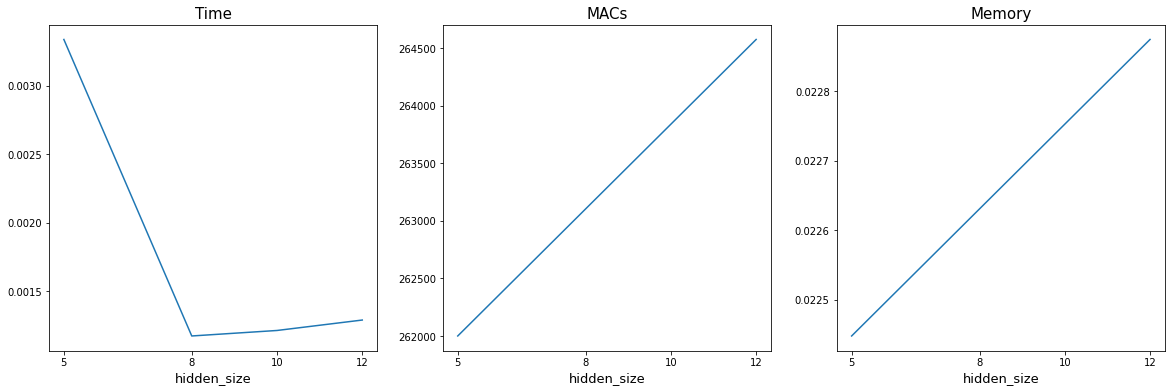

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(6)
fig.set_figwidth(20)
ax1.plot(att_dim[:len(ts)], ts)
ax1.set_title("Time", fontsize=15)
ax1.set_xlabel("hidden_size", fontsize=13)
ax1.set_xticks(att_dim[:len(ts)])
ax2.plot(att_dim[:len(macss)], macss)
ax2.set_title("MACs", fontsize=15)
ax2.set_xticks(att_dim[:len(macss)])
ax2.set_xlabel("hidden_size", fontsize=13)
ax3.plot(att_dim[:len(memory)], memory)
ax3.set_title("Memory", fontsize=15)
ax3.set_xlabel("hidden_size", fontsize=13)
ax3.set_xticks(att_dim[:len(memory)])
plt.show()

Let's try to teach the biggest model for more epochs.

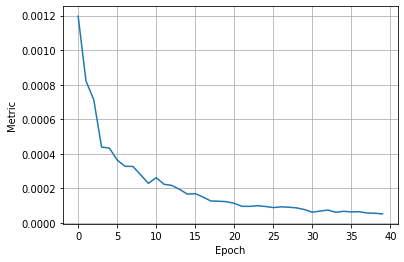

END OF EPOCH 39
 | Elapsed time : 0.0012826920
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 264576.0
Size of model: 0.022874832153320312


In [ ]:
history = defaultdict(list)
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=12)
model = CRNNSmall(config).to(config.device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
train(model, teacher_model, config, history)
t, macs, size = compute_metrics(model, config.device)
ts.append(t)
macss.append(macs)
memory.append(size)
val = np.array(history["val_metric"])
val_score.append(val.min())
best_epoch.append(val.argmin())
torch.save(model.state_dict(), f'/content/drive/MyDrive/distill_att_{att}.pth')

In [ ]:
val

array([1.19578912e-03, 8.21698480e-04, 7.12393895e-04, 4.39453188e-04,
       4.33488624e-04, 3.63948792e-04, 3.28104717e-04, 3.27355790e-04,
       2.79454286e-04, 2.29177697e-04, 2.62211057e-04, 2.24224633e-04,
       2.17367921e-04, 1.94303349e-04, 1.66840695e-04, 1.69761810e-04,
       1.50346394e-04, 1.27433995e-04, 1.26028637e-04, 1.23402916e-04,
       1.13699684e-04, 9.64713742e-05, 9.63758934e-05, 1.00153351e-04,
       9.57313983e-05, 8.93073333e-05, 9.34100223e-05, 9.15183097e-05,
       8.75439230e-05, 7.79272201e-05, 6.27368277e-05, 6.93608055e-05,
       7.50269920e-05, 6.20565273e-05, 6.78510160e-05, 6.39959803e-05,
       6.54938347e-05, 5.82432644e-05, 5.66320265e-05, 5.26874776e-05])

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0015165806
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 264576.0
Size of model: 0.022874832153320312

Compression_rate: 
MACs: 3.419085631349782
size in Mb: 4.476694738597515
number of parameters:  5.464270340077486


The last validation score is 5.2e-5 so this model is acceptable.

# GRU to RNN

In [ ]:
class CRNNSmallRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.RNN(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = AttentionDistilled(config.hidden_size, config.attention_dim)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

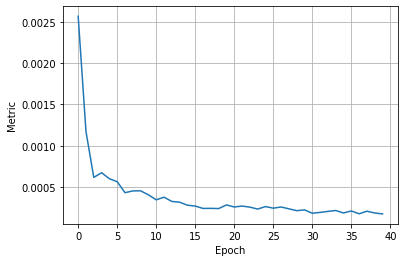

END OF EPOCH 39


In [ ]:
history = defaultdict(list)
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=12)
model = CRNNSmallRNN(config).to(config.device)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
train(model, teacher_model, config, history)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0025680296694530636,
              0.001172808093665433,
              0.000617575531622706,
              0.0006734556471723298,
              0.0006011588082270401,
              0.0005654579548229793,
              0.0004323130169667821,
              0.00045379618825882033,
              0.00045501356796536917,
              0.00040641982801229495,
              0.0003459626034679508,
              0.00037779946981323514,
              0.00032653226854381846,
              0.0003169961275091859,
              0.0002808566593579128,
              0.0002703299054248141,
              0.0002415812449527601,
              0.00024271209521938272,
              0.00024015201730708154,
              0.00028404929731381287,
              0.0002591586563529542,
              0.0002703358729723952,
              0.00025748774303024013,
              0.0002339218976323904,
              0.00026408785065496073,
              0.0002449737957526278

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0013840199
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 201096.0
Size of model: 0.012681961059570312

Compression_rate: 
MACs: 4.498388829215897
size in Mb: 8.07474808241841
number of parameters:  12.847672064777328


# Half Quantisation 

In [ ]:
def compute_metrics_quant(model, device):
    # making 2 second recording for test
    batch = next(iter(train_loader))[0][:2, :]
    melspec_train.to(device)
    long_wav = melspec_train(torch.cat([batch[0, :], batch[1, :]]).unsqueeze(0).to(device)).half()
    with Timer("", verbose=True) as t:
        with torch.no_grad():
            _ = model(long_wav)
    time = t.t
    macs, params = profile(model, (long_wav, ))
    print(f"MAC'c: {macs}")
    size = get_size_in_megabytes(model)
    print(f"Size of model: {size}")
    return time, macs, size

In [ ]:
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=12)
model = CRNNSmall(config).to(config.device)
model.load_state_dict(torch.load('/content/drive/MyDrive/distill_att_12.pth'), strict=False)
model = model.half()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
t, macs, size = compute_metrics_quant(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0987186432
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 264576.0
Size of model: 0.014085769653320312

Compression_rate: 
MACs: 3.419085631349782
size in Mb: 7.2700067704807045
number of parameters:  5.464270340077486


In [ ]:
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=15)
model = CRNNSmall(config).to(config.device)
model.load_state_dict(torch.load('/content/drive/MyDrive/distill_hidden_15.pth'), strict=False)
model = model.half()

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
t, macs, size = compute_metrics_quant(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0020258427
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 265680.0
Size of model: 0.014207839965820312

Compression_rate: 
MACs: 3.4048780487804877
size in Mb: 7.207544636864009
number of parameters:  5.40493932297211


A lot of improvement in memory

# LSTM instead of GRU

We have a good model(/distill_hidden_15.pth). Now we are going to change the GRU to LSTM and add distillation loss to layer outputs.

In [ ]:
class CRNNSmall(nn.Module):

    def __init__(self, config: SmallConfig, rnn_type=nn.GRU):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = rnn_type(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = AttentionDistilled(config.hidden_size, config.attention_dim)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input, return_layers=False):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        if return_layers:
            return output, conv_output, gru_output, contex_vector 
        return output

In [ ]:
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=15)
teacher_model = CRNNSmall(config).to(config.device)
teacher_model.load_state_dict(torch.load('/content/drive/MyDrive/distill_hidden_15.pth'), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['total_ops', 'total_params', 'conv.1.total_ops', 'conv.1.total_params', 'attention.total_ops', 'attention.total_params', 'attention.energy.1.total_ops', 'attention.energy.1.total_params'])

In [ ]:
set_random_seed()
model = CRNNSmall(config, rnn_type=nn.LSTM).to(config.device)

In [ ]:
def train_epoch_distil_layer(model, teacher, opt, loader, log_melspec, device, config):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits, conv, gru, contex = model(batch, return_layers=True)
        with torch.no_grad():
            teacher_logits, teacher_conv, teacher_gru, teacher_contex = teacher(batch, return_layers=True)
        # we need probabilities so we use softmax & CE separately
        probs = softmax_with_temp(logits)
        true_loss = F.cross_entropy(logits, labels)
        teacher_loss = F.cross_entropy(
                                    softmax_with_temp(logits, config.temperature),
                                    softmax_with_temp(teacher_logits, config.temperature)
        ) + F.mse_loss(conv, teacher_conv) + F.mse_loss(gru, teacher_gru) + F.mse_loss(contex, teacher_contex)
        loss =  (1 - config.teacher_loss_coeff) * true_loss + config.teacher_loss_coeff * teacher_loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train(model, teacher_model, config, history):
    set_random_seed()
    for n in range(config.num_epochs):

        train_epoch_distil_layer(model, teacher_model, opt, train_loader,
                    melspec_train, config.device, config)

        au_fa_fr = validation(model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)
        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()

        print('END OF EPOCH', n)
        if au_fa_fr < 5e-5:
            break

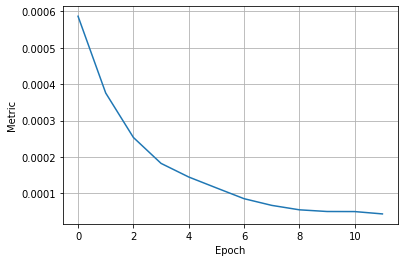

END OF EPOCH 11
CPU times: user 2min 31s, sys: 20.6 s, total: 2min 52s
Wall time: 9min 26s


In [ ]:
%%time

set_random_seed()
history = defaultdict(list)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
train(model, teacher_model, config, history)

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/distilled_model_lstm.pth")

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0018031597
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 296730.0
Size of model: 0.028123855590820312

Compression_rate: 
MACs: 3.048589626933576
size in Mb: 3.641166497117667
number of parameters:  0.7786803713527851


In [ ]:
model_q = model.half()
t, macs, size = compute_metrics_quant(model_q, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0022566319
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_lstm() for <class 'torch.nn.modules.rnn.LSTM'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 296730.0
Size of model: 0.016710281372070312

Compression_rate: 
MACs: 3.048589626933576
size in Mb: 6.128181714416162
number of parameters:  0.7786803713527851


Next we are trying to improve RNN with distillation function on layers 

In [ ]:
set_random_seed()
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=15, teacher_loss_coeff=0.7)
model = CRNNSmall(config, rnn_type=nn.RNN).to(config.device)

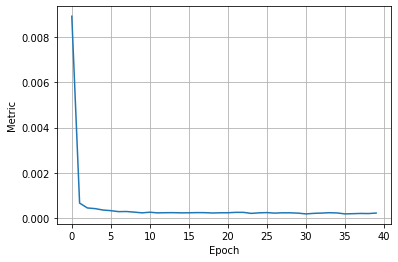

END OF EPOCH 39
CPU times: user 8min 4s, sys: 1min 7s, total: 9min 12s
Wall time: 29min 4s


In [ ]:
%%time

set_random_seed()
history = defaultdict(list)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
train(model, teacher_model, config, history)
torch.save(model.state_dict(), "/content/drive/MyDrive/distilled_model_rnn.pth")

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.00890698249315485,
              0.0006752996193748964,
              0.000460008405290768,
              0.00043044815834768153,
              0.00036867210578790953,
              0.0003413049325808852,
              0.00029791191034475866,
              0.0003035930156419865,
              0.00027691211040679133,
              0.0002447171912066396,
              0.0002721142021515694,
              0.00024295079712262759,
              0.00025110246711843986,
              0.00025271967251292387,
              0.00024428156023321773,
              0.00024674615738422094,
              0.00025497540549858784,
              0.0002531582872601362,
              0.00023857061719808424,
              0.0002476383057475987,
              0.0002485215027896047,
              0.0002657736828466276,
              0.000265403694896598,
              0.00022073958502569254,
              0.00024500960103811454,
              0.000255578127804281

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0010862350
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 202200.0
Size of model: 0.012865066528320312

Compression_rate: 
MACs: 4.473827893175074
size in Mb: 7.959822090437361
number of parameters:  2.3172175629008387


In [ ]:
model_q = model.half()
t, macs, size = compute_metrics_quant(model_q, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0015423298
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 202200.0
Size of model: 0.009080886840820312

Compression_rate: 
MACs: 4.473827893175074
size in Mb: 11.276832598193657
number of parameters:  2.3172175629008387


Увеличим вес учителя при обучении

In [ ]:
set_random_seed()
config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=15, teacher_loss_coeff=0.9)
model = CRNNSmall(config, rnn_type=nn.RNN).to(config.device)

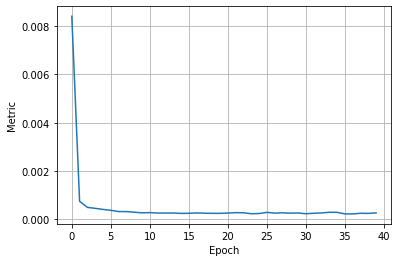

END OF EPOCH 39
CPU times: user 7min 43s, sys: 1min 6s, total: 8min 49s
Wall time: 28min 8s


In [ ]:
%%time

set_random_seed()
history = defaultdict(list)
opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)
train(model, teacher_model, config, history)
torch.save(model.state_dict(), "/content/drive/MyDrive/distilled_model_rnn_1.pth")

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.008414740379604654,
              0.0007415274624301853,
              0.0004894821227939282,
              0.0004505498423746901,
              0.0004054053449235042,
              0.0003689376616552693,
              0.0003166440422018998,
              0.0003148537779275632,
              0.00029020780641753047,
              0.0002643504227485301,
              0.00027330472789400325,
              0.00025549458213814546,
              0.00025481428171389756,
              0.00025585561876680335,
              0.00024099344151601966,
              0.00024511701689457476,
              0.00025989266470543215,
              0.0002477308027351061,
              0.0002434461035718607,
              0.0002424883121850907,
              0.00025464122283404506,
              0.00027093262773050737,
              0.0002668090523519522,
              0.00022662955448825967,
              0.00023491549430464722,
              0.0002828617553451

In [ ]:
t, macs, size = compute_metrics(model, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.0011990070
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 202200.0
Size of model: 0.012865066528320312

Compression_rate: 
MACs: 4.473827893175074
size in Mb: 7.959822090437361
number of parameters:  2.3172175629008387


In [ ]:
model_q = model.half()
t, macs, size = compute_metrics_quant(model_q, config.device)
print()
print(f"Compression_rate: ")
print(f"MACs: {teacher_macs / macs}")
print(f"size in Mb: {teacher_size / size}")
print(f"number of parameters:  {sum([p.numel() for p in teacher_model.parameters()]) / sum([p.numel() for p in model.parameters()])}")

 | Elapsed time : 0.1005673409
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_rnn() for <class 'torch.nn.modules.rnn.RNN'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
MAC'c: 202200.0
Size of model: 0.009080886840820312

Compression_rate: 
MACs: 4.473827893175074
size in Mb: 11.276832598193657
number of parameters:  2.3172175629008387


Did't help. So the best copression rates are:

MACs: 3.419085631349782

size in Mb: 7.2700067704807045

For model distilled_att_12

### Streaming KWS model

In [9]:
import typing as tp
class StreamingKWS(nn.Module):
    def __init__(self, model_class: type, config: SmallConfig):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
        )
        self.model = model_class(config)
        self.max_window_length = config.max_window_length
        self.buffer: Optional[torch.Tensor] = torch.zeros(1, self.max_window_length, config.hidden_size)
        self.hidden: Optional[torch.Tensor] = torch.zeros(1, 1, config.hidden_size)
        self.overlap = config.kernel_size[0] - config.stride[0]
        self.overlap = max(0, self.overlap)

    def mel(self, batch):
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

    def forward(self, input: torch.Tensor) -> tp.Any:
        if self.training:
            return self.model(self.mel(input))
        else:
            # if batch contains only one wav and batch dimension doesn't exist
            if len(input.shape) == 1:
                input = input.unsqueeze(0)
            input = self.mel(input)
            # if you want lower memory and have gpu available use this
            #
            #    input = input.half()
            input = input.unsqueeze(dim=1)
            conv_output = self.model.conv(input).transpose(-1, -2)
            # works only for unidirectional gru, but we don't need biderectional
            # because it's much more complex to compute and it works
            gru_output, self.hidden = self.model.gru(conv_output, hx=self.hidden)
            if self.buffer is None:
                self.buffer = gru_output.clone()
            else:
                self.buffer = torch.cat([self.buffer, gru_output.clone()], dim=1)[:, -self.max_window_length:, :]
            att = self.model.attention(self.buffer)
            output = self.model.classifier(att)
            out = F.softmax(output, dim=-1)[:, 1].cpu().item()
            return out

config = SmallConfig(cnn_out_channels=4, hidden_size=15, attention_dim=12)
model_stream = StreamingKWS(CRNNSmall, config)
model_dist = CRNNSmall(config).to(config.device)
model_dist.load_state_dict(torch.load('distill_att_12.pth', map_location=torch.device('cpu')), strict=False)
# model_dist = model_dist.half()
model_stream.model = model_dist
compiled_model = torch.jit.script(model_stream)
torch.jit.save(compiled_model, 'stream_model.pth')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:70: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [87]:
import librosa

class MySpeechDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):
        self.transform = transform
        path2dir = pathlib.Path(path2dir)
        triplets = []
        paths = (path2dir).rglob('*.wav')
        for path2wav in paths:
            triplets.append(path2wav.as_posix())
        self.csv = pd.DataFrame(
                triplets,
                columns=['path']
        )
        set_random_seed()
        self._where = torch.rand(size=(len(self.csv),))
        self._sheila, _ = torchaudio.load("speech_commands/sheila/004ae714_nohash_0.wav")
        self._sheila = self._sheila.squeeze()


    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = librosa.load(path2wav)
        wav = librosa.resample(wav, orig_sr=sr, target_sr=48000)
        wav = torch.tensor(wav[::3])
        idx = int(self._where[index] * len(wav))
        wav = torch.cat([wav[:idx], self._sheila, wav[idx:]])

        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'label': path2wav,
            'idx' : self._where[index]
        }

    def __len__(self):
        return len(self.csv)

In [88]:
my_dataset = MySpeechDataset(path2dir='audio/')

In [92]:
my_dataset[0]

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


{'wav': tensor([ 8.5809e-03,  1.4300e-02,  1.4781e-02,  ..., -1.0504e-02,
         -7.0599e-03, -4.9066e-05]),
 'label': 'audio/claudia.wav',
 'idx': tensor(0.8823)}

In [93]:
my_loader = DataLoader(dataset=my_dataset,
                       batch_size=1,
                       shuffle=False,
                       )

In [95]:
from collections import defaultdict

model_stream.eval()

probs = defaultdict(list)
idxs = {}
frames_per_chunk = 16000
for dct in my_loader:
    model_stream.buffer = None
    wav = dct['wav']
    name = dct['label'][0]
    idxs[name] = dct['idx']
    for i in range(0, wav.shape[-1] - frames_per_chunk, frames_per_chunk):
        probs[name].append(model_stream(wav[..., i:i+frames_per_chunk]))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/usr/local/lib/python3.7/dist-packages/librosa/cor

Dots below are approximate beggining of "sheila" word in the input sequence.

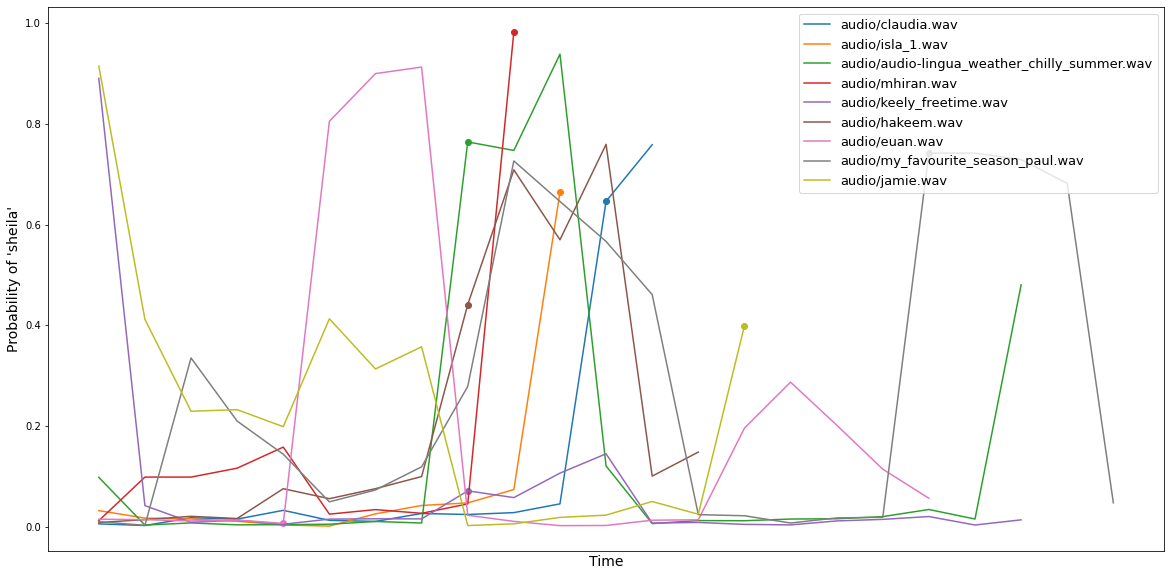

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 10])
for name, prob in probs.items():
    plt.plot(prob, label=name)
    idx_sh = int(len(prob) * idxs[name])
    plt.scatter(idx_sh, prob[idx_sh])

plt.xlabel('Time', fontsize=14)
plt.xticks([])
plt.ylabel("Probability of 'sheila'", fontsize=14)
plt.legend(fontsize=13, loc='upper right')
plt.show()